In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import datetime
import os
import matplotlib.pyplot as plt
import scipy
from scipy import signal

C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\USER\anaconda3\envs\nilmtk\lib\site-package

# Derive ON Signatures

In [3]:
SIG_SIZE = 90 # 1 sec contains 30 samples ; 3 seconds 90 samples.
THRSHLD =30
db = np.array([])
name = []
appliances = ['ceilingfan','drill', 'fan', 'hairdryer', 'heater', 'induction', 'iron', 'spinner', 'toaster', 'washing machine']

In [4]:
def get_train_sig(appliances,db,name):
    for appliance_name in appliances:
        data = pd.read_csv(f'../{appliance_name}.txt')
        data['Active Power']= abs(data['Active Power'])
        data['T'] = pd.to_datetime(data['T'])
        data = data.set_index(data['T'])
        data =  data.resample('33ms').mean()
        data = data.dropna()
        data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
        dbydx = np.gradient(data)
        on_events = []
        for idx,x in enumerate(dbydx):
            if x> THRSHLD:
                on_events.append(idx)
        for x in on_events:
            sig = data[x:x+SIG_SIZE]
            if len(sig) == SIG_SIZE:
                db = np.append(db,sig,axis = 0)
                name.append(f'{appliance_name}')
    return db, name

db, name = get_train_sig(appliances,db,name)

In [5]:
db = db.reshape((db.shape[0]//SIG_SIZE,SIG_SIZE))

In [6]:
len(db),db.shape

(1841, (1841, 90))

# Using Simple Models

In [372]:
def train_model(db, name):
    
    from sklearn.ensemble import RandomForestClassifier

    clf = RandomForestClassifier()

    from sklearn.model_selection import train_test_split

    X = db
    y = name

    X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

    clf.fit(X_train,y_train)
    
    return clf,X_test,y_test

clf,X_test,y_test = train_model(db,name)

In [8]:
def pred_mains(clf,X_test,y_test=[]):
    if len(y_test) != 0:
        pred = clf.predict(X_test)
        preds = pred == y_test
        print(f'Total number of predictions = {preds.size}\n',
              f'Number of {np.unique(preds,return_counts=True)[0][0]} predictions = {np.unique(preds,return_counts=True)[1][0]}\n',
              f'Number of {np.unique(preds,return_counts=True)[0][1]} predictions= {np.unique(preds,return_counts=True)[1][1]}\n',
              f'Accuracy = {(np.unique(preds,return_counts=True)[1][1])/(preds.size)*100:.2f}%')
        return pred
    else:
        return clf.predict(X_test)

preds = pred_mains(clf,X_test,y_test)

Total number of predictions = 369
 Number of False predictions = 14
 Number of True predictions= 355
 Accuracy = 96.21%


# Create Dummy Data

In [9]:
def dummy(appliances):
    length = 27000 #length of mains data

    vamp = (np.array([4]*length)) # phantom signal
    for ix, appliance_name in enumerate(appliances):
        data = pd.read_csv(f'../{appliance_name}.txt')
        data['Active Power']= abs(data['Active Power'])
        data['T'] = pd.to_datetime(data['T'])
        data = data.set_index(data['T']) #preprocessing
        data =  data.resample('33ms').mean() 
        data = data.dropna()
        data = scipy.signal.medfilt(data['Active Power'], kernel_size=None)
        dbydx =(np.gradient(data))
        on_events = []
        for idx,x in enumerate(dbydx):
            if x> THRSHLD:
                on_events.append(idx)
        for e in on_events:
            if data[e-1] < 10:
                x=e
                break
        mltplr = 1000*(1 + ix)
        sig = data[x:x+SIG_SIZE]
        if len(sig) == SIG_SIZE:
            sig = np.array(sig,dtype=float)
            _ = sig[-1]
            sig = np.append(sig,np.array([_]*(length-SIG_SIZE)))
            sig[2500:] = 0
            vamp[mltplr:] = np.add(vamp[mltplr:],sig[:(length-mltplr)])
            time_range= pd.date_range(start='2020-11-01',periods=length,freq='30ms')
            test_df = pd.DataFrame({'data':vamp,'time':time_range})
#             test_df = test_df.set_index(test_df['time'])
#             test_df = test_df.drop('time',axis = 1)
    return test_df

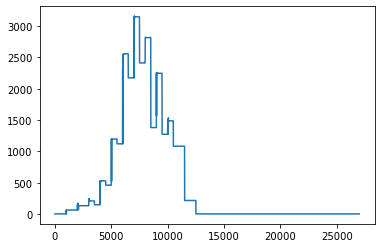

In [10]:
vamp_df = dummy(appliances)
vamp = vamp_df['data']
plt.plot(vamp);

pd.Series(vamp).to_csv('../track_test.txt',index = False)

# Using Buffer

In [100]:
def event_detection(data):
    data = scipy.signal.medfilt(data, kernel_size=None)
    dbydx = (np.gradient(data))
    on_events = []
    for idx,x in enumerate(dbydx):
        if x > THRSHLD:
            on_events.append(idx)
    for x in on_events:
        for y in range(x+1,x+91): # to remove false turn on signatures, give delay for transition
            if y in on_events:
                on_events.remove(y)
    return on_events

In [30]:
def get_value(indx):
    indx = indx*SIG_SIZE
    return vamp_df[indx:indx+SIG_SIZE]

In [538]:
BUFFER_SIZE = 4
indx = 0
count = 0
buffer = np.array([0]*SIG_SIZE*BUFFER_SIZE)
test_vamp_db = np.array([])
time = []
test_on_events = []
idx_on_events = []
i = 1
prev_mean = 0
I = 0

In [539]:
for itr in range(300): # because 300 times we can get data from 27000 length of vamp
    while count!= BUFFER_SIZE: 
        buffer = np.roll(buffer, -SIG_SIZE) # helps getting data in seconds
        test_df = get_value(indx)
        buffer[SIG_SIZE*(BUFFER_SIZE-1):] = test_df['data']
        t = test_df['time']
        for ts in t:
            time.append(ts)
        count += 1
    buffer = buffer.flatten()
    count = 0
    events = event_detection(buffer)
    indx += 1
    if len(events)>0:
        for ev in events:
            sig = buffer[ev:ev+SIG_SIZE]
            if len(sig) == SIG_SIZE:
                sig = sig - prev_mean
                prev_mean = buffer[:ev].mean()
                if math.isnan(prev_mean):
                    prev_mean = 0
                I = (vamp_df[vamp_df['time']==time[ev]].index.values[0])
                if len(idx_on_events) ==0:
                    idx_on_events.append(I)
                    test_vamp_db = np.append(test_vamp_db, sig, axis = 0)
                    test_on_events.append(time[ev])
                if not any(ele >= (I-90) and ele < I for ele in idx_on_events):
                    if I not in idx_on_events:
                        idx_on_events.append(I)
                        test_vamp_db = np.append(test_vamp_db, sig, axis = 0)
                        test_on_events.append(time[ev])
    time = [] 

C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [540]:
test_vamp_db = test_vamp_db.reshape((test_vamp_db.shape[0]//SIG_SIZE,SIG_SIZE))
test_vamp_db.shape

(28, 90)

# STABLE CODE

In [410]:
vamp_db = np.array([])
data = scipy.signal.medfilt(vamp, kernel_size=None)
dbydx = (np.gradient(data))
on_events = []
for idx,x in enumerate(dbydx):
    if x > THRSHLD:
        on_events.append(idx)
for x in on_events:
    for y in range(x+1,x+91): # to remove false turn on signatures, give delay for transition
        if y in on_events:
            on_events.remove(y)
            
for x in on_events:
    sig = data[x:x+SIG_SIZE]
    sig = sig - data[x-270:x].mean()
    if len(sig) == SIG_SIZE:
        vamp_db = np.append(vamp_db, sig, axis = 0)

In [411]:
vamp_db = vamp_db.reshape((vamp_db.shape[0]//SIG_SIZE,SIG_SIZE))
vamp_db.shape

(10, 90)

# Major Categorical Classification

In [443]:
test_preds = clf.predict(test_vamp_db)

In [444]:
len(test_preds),len(test_on_events)

(28, 28)

In [445]:
len(idx_on_events)

28

In [446]:
df = pd.DataFrame({'Location':idx_on_events, 'Prediction': test_preds, 'actual':'na','TS':test_on_events})

In [447]:
for idx, x in enumerate(df['Location']):
    if x < 2000:
        df.loc[[idx],["actual"]] = appliances[0]
    elif x < 3000 and x >= 2000:
        df.loc[[idx],["actual"]] = appliances[1]
    elif x < 4000 and x >= 3000:
        df.loc[[idx],["actual"]] = appliances[2]
    elif x < 5000 and x >= 4000:
        df.loc[[idx],["actual"]] = appliances[3]
    elif x < 6000 and x >= 5000:
        df.loc[[idx],["actual"]] = appliances[4]
    elif x < 7000 and x >= 6000:
        df.loc[[idx],["actual"]] = appliances[5]
    elif x < 8000 and x >= 7000:
        df.loc[[idx],["actual"]] = appliances[6]
    elif x < 9000 and x >= 8000:
        df.loc[[idx],["actual"]] = appliances[7]
    elif x < 10000 and x >= 9000:
        df.loc[[idx],["actual"]] = appliances[8]
    elif x >= 10000:
        df.loc[[idx],["actual"]] = appliances[9]

In [448]:
df.sort_values(by=['Location'])

,Location,Prediction,actual,TS
0,1000,fan,ceilingfan,2020-11-01 00:00:30.000
1,2000,drill,drill,2020-11-01 00:01:00.000
2,3000,drill,fan,2020-11-01 00:01:30.000
4,3420,ceilingfan,fan,2020-11-01 00:01:42.600
3,3509,ceilingfan,fan,2020-11-01 00:01:45.270
5,4000,hairdryer,hairdryer,2020-11-01 00:02:00.000
6,5000,spinner,heater,2020-11-01 00:02:30.000
8,5490,fan,heater,2020-11-01 00:02:44.700
7,5579,spinner,heater,2020-11-01 00:02:47.370
9,6000,hairdryer,induction,2020-11-01 00:03:00.000


In [429]:
actual = df['actual']

In [430]:
test_preds_proba = clf.predict_proba(test_vamp_db)

In [433]:
pd.DataFrame(test_preds_proba,columns=appliances)

,ceilingfan,drill,fan,hairdryer,heater,induction,iron,spinner,toaster,washing machine
0,0.37,0.16,0.42,0.00,0.00,0.01,0.00,0.02,0.00,0.02
1,0.16,0.61,0.01,0.00,0.00,0.04,0.00,0.16,0.00,0.02
2,0.12,0.58,0.06,0.00,0.00,0.05,0.00,0.15,0.00,0.04
3,0.81,0.02,0.02,0.00,0.00,0.05,0.03,0.06,0.00,0.01
4,0.75,0.01,0.02,0.00,0.00,0.13,0.03,0.04,0.01,0.01
5,0.00,0.03,0.00,0.38,0.00,0.09,0.01,0.20,0.24,0.05
6,0.00,0.00,0.00,0.18,0.01,0.21,0.03,0.29,0.04,0.24
7,0.00,0.00,0.00,0.02,0.35,0.02,0.00,0.61,0.00,0.00
8,0.00,0.19,0.64,0.00,0.01,0.00,0.02,0.00,0.14,0.00
9,0.00,0.00,0.00,0.54,0.16,0.01,0.11,0.01,0.16,0.01


# Tracking Devices

In [421]:
tracking_df = pd.DataFrame({'Location':idx_on_events,
              'Prediction': test_preds,
              'Accuracy':[ x.max() for x in test_preds_proba],
              })
tracking_df = tracking_df.sort_values(by=['Location'])
tracking_df['Actual'] = actual
tracking_df

,Location,Prediction,Accuracy,Actual
0,1000,fan,0.42,ceilingfan
1,2000,drill,0.61,drill
2,3000,drill,0.58,fan
4,3420,ceilingfan,0.75,fan
3,3509,ceilingfan,0.81,fan
5,4000,hairdryer,0.38,hairdryer
6,5000,spinner,0.29,heater
8,5490,fan,0.64,heater
7,5579,spinner,0.61,heater
9,6000,hairdryer,0.54,induction


In [422]:
import math
from statistics import mean

In [423]:
active_devices = 0
for x in idx_on_events:
    active_devices += 1
    rise = (vamp[x+270:x+270+SIG_SIZE].mean()) - (vamp[x-270:x].mean())
    if rise > 0 :
        for idx, l in enumerate(vamp):
            if idx < vamp.size-1:
                if l>vamp[idx+1] and idx < len(vamp):
                    fall = l - mean(vamp[idx+1:idx+91])
                    if math.isclose(fall,rise,abs_tol=abs(rise*1/100)):
                        loc = idx
                        break
        duration = (loc-x)//30
        print(f'device no. {active_devices} turned on at location {x} with a rise of {rise} kWH & turned off at {loc} with a fall of {fall} & ran for {duration}s')
    else:
        idx_on_events.remove(x)
        active_devices -= 1

device no. 1 turned on at location 1000 with a rise of 62.0 kWH & turned off at 3499 with a fall of 62 & ran for 83s
device no. 2 turned on at location 2000 with a rise of 69.0 kWH & turned off at 4499 with a fall of 69 & ran for 83s
device no. 3 turned on at location 3000 with a rise of 76.0 kWH & turned off at 5499 with a fall of 76 & ran for 83s
device no. 4 turned on at location 4000 with a rise of 382.0 kWH & turned off at 6499 with a fall of 382 & ran for 83s
device no. 5 turned on at location 5000 with a rise of 735.0 kWH & turned off at 7499 with a fall of 735 & ran for 83s
device no. 6 turned on at location 6000 with a rise of 1434.0 kWH & turned off at 8499 with a fall of 1434 & ran for 83s
device no. 7 turned on at location 7000 with a rise of 972.0 kWH & turned off at 9499 with a fall of 972 & ran for 83s
device no. 8 turned on at location 8000 with a rise of 404.0 kWH & turned off at 10499 with a fall of 404 & ran for 83s
device no. 9 turned on at location 9000 with a rise

# Derive Signatures to train local database
* **Use signatures with high probability and club them together if they are running contagiously (tracking might help) and train the local model**
* **Once trained rerun the mains data to predict via local model**
* **Ask to name the clubbed signatures only once**

In [571]:
BUFFER_SIZE = 9
indx = 0
count = 0
buffer = np.array([0]*SIG_SIZE*BUFFER_SIZE)
prev_buffer = np.array([])
test_vamp_db = np.array([])
time = []
test_on_events = []
idx_on_events = []
i = 1
prev_mean = 0
I = 0
localsig_db = np.array([])
local_name = ['New']
active_devices = 0 
prev_guess = ''

In [572]:
#copying code from mains events detection and classification
#every time an event is detected increment active devices and classify also accounting for clubbing of signatures
for itr in range(300): # because 300 times we can get data from 27000 length of vamp
    while count!= BUFFER_SIZE: 
        buffer = np.roll(buffer, -SIG_SIZE) # helps getting data in seconds
        test_df = get_value(indx) # gets 90 samples
        buffer[SIG_SIZE*(BUFFER_SIZE-1):] = test_df['data']
        t = test_df['time']
        for ts in t:
            time.append(ts)
        count += 1
    buffer = buffer.flatten()
    count = 0
    events = event_detection(buffer)
    indx += 1
    if len(events)>0:
        for ev in events:
            sig = buffer[ev:ev+SIG_SIZE]
            if buffer[:ev].mean() < sig.mean():
                if len(sig) == SIG_SIZE:
                    sig = sig - prev_mean #remove bias
                    prev_mean = buffer[:ev].mean() #update bias
                    if math.isnan(prev_mean):
                        prev_mean = 0
                    I = (vamp_df[vamp_df['time']==time[ev]].index.values[0]) #get corresponding index from time stamp
                    if len(idx_on_events) ==0:
                        idx_on_events.append(I)
                        test_vamp_db = np.append(test_vamp_db, sig, axis = 0)
                        test_on_events.append(time[ev]) 
                        active_devices += 1
                        if (test_vamp_db.shape[0])!= 0:
                            temp_vamp_db = sig
                            temp_vamp_db = temp_vamp_db.reshape((1,90))
                            acc = clf.predict_proba(temp_vamp_db).max()
                            if acc > 0.80:
                                guess = appliances[clf.predict_proba(temp_vamp_db).argmax()]
                                if prev_guess == guess:
                                    print(f'It seems the same device at {I}, if true select from {local_name}, but if different, name it\n')
                                    name = input('Enter the name!\n')
                                    localsig_db = np.append(localsig_db,sig)
                                    local_name.append(name)
                                    prev_guess = guess
                                    #here might want to decrement active_devices and remove start time from it and club it!
                                else:
                                    name = input(f'An appliance  was detected at {I}! Some people named it as {guess}, would you like to name it?\n')
                                    localsig_db = np.append(localsig_db,sig)
                                    local_name.append(name)
                                    prev_guess = guess
                            else:
                                name = input(f'An unknown device was detected at {I}, please name it\n')
                                localsig_db = np.append(localsig_db,sig)
                                local_name.append(name)
                    if not any(ele >= (I-90) and ele < I for ele in idx_on_events): #remove false events during transition
                        if I not in idx_on_events:
                            idx_on_events.append(I)
                            test_vamp_db = np.append(test_vamp_db, sig, axis = 0)
                            test_on_events.append(time[ev])
                            active_devices += 1
                            if (test_vamp_db.shape[0])!= 0:
                                temp_vamp_db = sig
                                temp_vamp_db = temp_vamp_db.reshape((1,90))
                                acc = clf.predict_proba(temp_vamp_db).max()
                                if acc > 0.80:
                                    guess = appliances[clf.predict_proba(temp_vamp_db).argmax()]
                                    if prev_guess == guess:
                                        print(f'It seems the same device at {I}, if true select from {local_name}, but if different, name it\n')
                                        name = input('Enter the name!\n')
                                        localsig_db = np.append(localsig_db,sig)
                                        local_name.append(name)
                                        prev_guess = guess
                                        #here might want to decrement active_devices and remove start time from it and club it!
                                    else:
                                        name = input(f'An appliance  was detected at {I}! Some people named it as {guess}, would you like to name it?\n')
                                        localsig_db = np.append(localsig_db,sig)
                                        local_name.append(name)
                                        prev_guess = guess
                                else:
                                    name = input(f'An unknown device was detected at {I}, please name it\n')
                                    localsig_db = np.append(localsig_db,sig)
                                    local_name.append(name)
                        
                        
    time = []


An unknown device was detected at 1000, please name it
ceiling fan
An unknown device was detected at 2000, please name it
drill
An unknown device was detected at 3000, please name it
fan
An unknown device was detected at 4000, please name it
hairdryer
An unknown device was detected at 5000, please name it
induction
An unknown device was detected at 6000, please name it
heater
An unknown device was detected at 7000, please name it
iron 
An unknown device was detected at 8000, please name it
spinner


C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice.
C:\Users\USER\anaconda3\envs\nilmtk\lib\site-packages\numpy\core\_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


An unknown device was detected at 9007, please name it
toaster
An unknown device was detected at 10000, please name it
washing machine


In [574]:
localsig_db = localsig_db.reshape((localsig_db.shape[0]//SIG_SIZE,SIG_SIZE))

In [575]:
local_name = local_name[1:]

In [602]:
len(local_name), localsig_db.shape

(10, (10, 90))

# After training Period
* **Retrain Model using Local Signatures**

In [594]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier()

X = localsig_db
y = local_name

X_train , X_test , y_train , y_test = train_test_split(X,y,test_size = 0.2,random_state=42)

clf.fit(X_train,y_train)

new = (clf.predict(localsig_db))

In [579]:
new_proba = clf.predict_proba(localsig_db)

In [580]:
[new_proba.max() for x in new_proba]

[0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72, 0.72]

In [581]:
_ = np.array([4]*90)
_ = _.reshape((1,90))
clf.predict_proba(_)

array([[0.54, 0.28, 0.14, 0.  , 0.03, 0.01, 0.  , 0.  ]])

In [618]:
_ = 1
values= 0
for idx,x in enumerate(tracking_df['Location']):
    
    if x == 1000*(_+values):
        tracking_df.loc[[idx],["new2"]] = new[values]
        values += 1
    else:
        tracking_df.loc[[idx],["new2"]] = 'na'

In [619]:
tracking_df

,Location,Prediction,Accuracy,Actual,new2
0,1000,fan,0.42,ceilingfan,ceiling fan
1,2000,drill,0.61,drill,ceiling fan
2,3000,drill,0.58,fan,fan
4,3420,ceilingfan,0.75,fan,na
3,3509,ceilingfan,0.81,fan,na
5,4000,hairdryer,0.38,hairdryer,hairdryer
6,5000,spinner,0.29,heater,induction
8,5490,fan,0.64,heater,na
7,5579,spinner,0.61,heater,na
9,6000,hairdryer,0.54,induction,heater
